
---

# Aprendizaje de Máquina Supervisado

---


# Author: **Alejandro Barrenechea**

---



#   Caso Kyphosis

La Kyphosis es una curvatura convexa excesivamente anormal de la espira vertebral.

<img src="../images/Image_1.png" width="800" alt="Descripción de la imagen">

Se recopilaron datos de 83 pacientes sometidos a cirugía espinal correctiva. El objetivo fue determinar los factores de riesgo importantes para la cifosis después de la cirugía.

Los factores de riesgo son la edad en años, el nivel vertebral inicial de la cirugía y el número de niveles involucrados.

El dataset kyphosis contiene 81 filas y 4 columnas. Representa datos de niños que han tenido intervenciones quirúrgicas a la columna. El dataset contiene las siguientes columnas:

*Entradas*

- Age: edad en meses.
- Number: el número de vértebras involucradas.
- Start: el número de la primera vértebra operada.

*Salida*
- Kyphosis: vatiable categórica con valores present o absent que indica si se desarrolló kyphosis después de la operación



## Desarrollaremos los siguiente puntos

1. Un análisis exploratorio de los datos:

    • ¿Qué porcentaje de la muestra presenta cifosis?

    • ¿Cuál es la edad promedio de niños con cifosis?

2. Ajustar un árbol de decisión.

3. Evaluar el performance.

4. Accuracy:

    • Sensibilidad

    • Especificidad
    
    • ¿Afecta el desbalance?

5. Crear un gráfico del árbol ajustado.
6. Realizar un modelo con Árboles Aleatorios.
7. Evaluar el performance ¿Qué se observa?


---

## 1. Análisis Exploratorio de Datos

In [ ]:
%pip install pandas numpy matplotlib seaborn scikit-learn

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Esto asegura que los gráficos se vean
%matplotlib inline

# Cargamos los datos
try:
    df = pd.read_csv('../data/kyphosis.csv')
    print("✅ Datos cargados correctamente.")
    print("Dimensiones:", df.shape)
    display(df.head())
except FileNotFoundError:
    print("❌ Error de archivo: No encuentro 'kyphosis.csv' en la carpeta 'data'.")
except Exception as e:
    print(f"❌ Ocurrió un error: {e}")

✅ Datos cargados correctamente.
Dimensiones: (81, 4)


,Kyphosis,Age,Number,Start
0,absent,71,3,5
1,absent,158,3,14
2,present,128,4,5
3,absent,2,5,1
4,absent,1,4,15


### Validación de Estructura y Tipos

In [5]:
# Revisión técnica de los datos
print("--- Información del Dataset ---")
df.info()

print("\n--- Estadísticas Descriptivas Generales ---")
display(df.describe())

--- Información del Dataset ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 81 entries, 0 to 80
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Kyphosis  81 non-null     object
 1   Age       81 non-null     int64 
 2   Number    81 non-null     int64 
 3   Start     81 non-null     int64 
dtypes: int64(3), object(1)
memory usage: 2.7+ KB

--- Estadísticas Descriptivas Generales ---


,Age,Number,Start
count,81.000000,81.000000,81.000000
mean,83.654321,4.049383,11.493827
std,58.104251,1.619423,4.883962
min,1.000000,2.000000,1.000000
25%,26.000000,3.000000,9.000000
50%,87.000000,4.000000,13.000000
75%,130.000000,5.000000,16.000000
max,206.000000,10.000000,18.000000


#### Validación Técnica del Dataset

Antes de proceder con el análisis exploratorio, se observan los siguientes puntos clave de la integridad y estructura de los datos:

1.  **Integridad de los Datos:**
    *   El dataset consta de **81 registros** (filas).
    *   No existen valores nulos (`81 non-null` en todas las columnas), por lo que no se requiere imputación de datos faltantes.

2.  **Tipos de Datos:**
    *   `Kyphosis`: Es de tipo `object` (categórica), lo cual es correcto para nuestra variable objetivo (clases).
    *   `Age`, `Number`, `Start`: Son de tipo `int64` (numéricas discretas), formato adecuado para el procesamiento matemático.

3.  **Coherencia Estadística (Variables Numéricas):**
    *   **Age (Edad):** Rango de 1 a 206 meses (aprox. 17 años). Esto confirma que el estudio se centra en una población pediátrica. La alta desviación estándar (58.1) indica una muestra muy heterogénea en edades.
    *   **Number (Vértebras involucradas):** Varía entre 2 y 10 vértebras, con una media cercana a 4.
    *   **Start (Vértebra superior):** Rango de 1 a 18, consistente con la numeración anatómica vertebral.

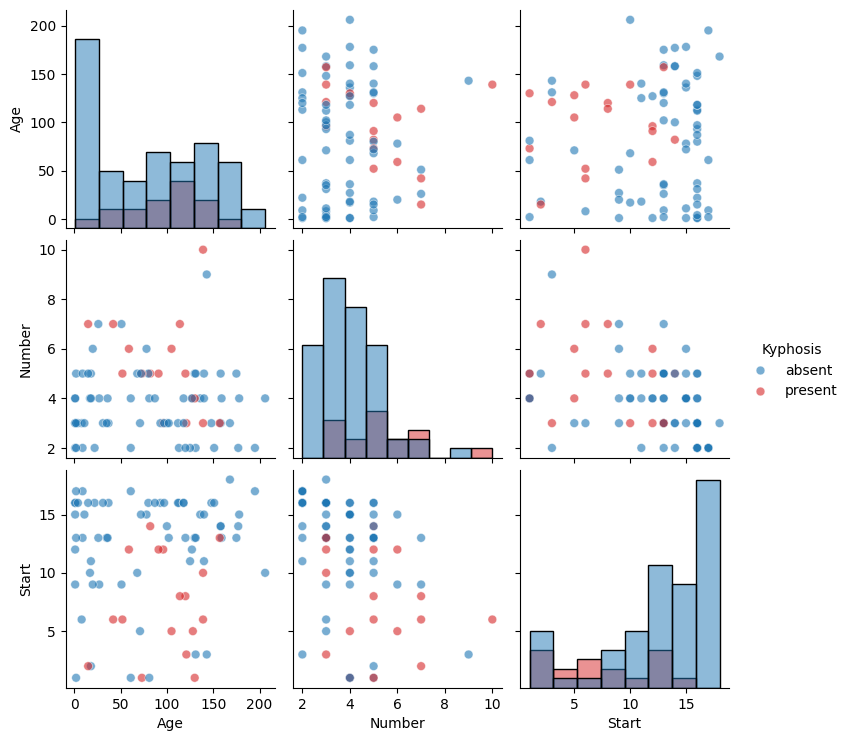

In [7]:
# Visualización Exploratoria Multivariable
# Usamos pairplot para cruzar todas las variables numéricas entre sí.
# hue='Kyphosis': Colorea los puntos según si tienen cifosis o no.
# diag_kind='hist': Muestra histogramas en la diagonal principal para ver distribuciones.

colores = {'absent': '#1f77b4', 'present': '#d62728'} # Azul y Rojo estándar

sns.pairplot(df, hue='Kyphosis', palette=colores, diag_kind='hist',
             plot_kws={'alpha': 0.6, 's': 40}) # 's' aumenta el tamaño del punto
plt.show()

#### Análisis Visual Multivariable

A partir de la matriz de dispersión y los histogramas, se observan los siguientes patrones críticos:

1.  **Separabilidad de Clases (Complejidad del Problema):**
    *   No existe una separación lineal clara entre los pacientes con Cifosis (`present`) y los sanos (`absent`).
    *   Los puntos rojos (enfermos) se encuentran mezclados dentro de la nube de puntos azules. Esto indica que un modelo lineal simple (como una Regresión Logística básica) tendría dificultades, justificando el uso de modelos no lineales como **Árboles de Decisión**.

2.  **Distribución de la variable 'Start' (Vértebra de inicio):**
    *   Observando el histograma y los gráficos de dispersión de la variable `Start`, se nota una tendencia: los casos `absent` (azules) tienen una fuerte concentración en valores altos (> 12).
    *   Por el contrario, los casos `present` (rojos) parecen distribuirse más uniformemente en valores bajos de `Start`. Esto sugiere que `Start` podría ser una variable discriminante importante para el árbol.

3.  **Desbalance de Clases:**
    *   Visualmente se confirma el fuerte desbalance: la cantidad de puntos azules domina significativamente sobre los rojos en todos los cuadrantes.

### ¿Qué porcentaje de la muestra presenta cifosis?

In [9]:
# Cálculo del porcentaje de Cifosis
# value_counts nos da el conteo, normalize=True nos da la proporción (0 a 1)
conteo_clases = df['Kyphosis'].value_counts(normalize=True) * 100

print("--- Distribución Porcentual (%) ---")
print(conteo_clases)
print("\n")

--- Distribución Porcentual (%) ---
Kyphosis
absent     79.012346
present    20.987654
Name: proportion, dtype: float64




**Prevalencia de la Cifosis:**
    *   El **20.99%** de la muestra presenta Cifosis (clase `present`).
    *   El **79.01%** corresponde a casos negativos (clase `absent`).
    *   *Observación:* Existe un desbalance de clases evidente (proporción 4:1). Esto implica que un modelo base que prediga siempre "ausente" tendría una exactitud engañosa del 79%.

### ¿Cuál es la edad promedio de niños con cifosis?

In [10]:
# Cálculo de la Edad Promedio (Solo casos positivos)
# Filtramos el dataframe donde Kyphosis es 'present'
casos_positivos = df[df['Kyphosis'] == 'present']
edad_media = casos_positivos['Age'].mean()

print(f"--- Edad Promedio de casos 'present' ---")
print(f"Media: {edad_media:.2f} meses")
print(f"Mínima: {casos_positivos['Age'].min()} meses")
print(f"Máxima: {casos_positivos['Age'].max()} meses")

--- Edad Promedio de casos 'present' ---
Media: 97.82 meses
Mínima: 15 meses
Máxima: 157 meses


**Perfil Etario (Casos Positivos):**
    *   La edad promedio de los niños afectados es de **97.82 meses** (aprox. 8 años).
    *   Sin embargo, el rango es amplio, afectando desde bebés de **15 meses** hasta adolescentes de **157 meses**.


---

##  2.  Ajustar un Árbol de Decisión

Para garantizar la validez externa del modelo y evitar el sobreajuste (*overfitting*), se procedió a dividir el conjunto de datos en:

1.  **Conjunto de Entrenamiento (Train):** 70% de los datos (56 registros). Utilizado para que el algoritmo aprenda los patrones.
2.  **Conjunto de Prueba (Test):** 30% de los datos (25 registros). Utilizado estrictamente para evaluar el rendimiento final.

Se instanció un `DecisionTreeClassifier` con los hiperparámetros por defecto para establecer una línea base de desempeño.

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

# Definición de variables X (Features) e y (Target)
X = df.drop('Kyphosis', axis=1) # Todas las columnas menos la objetivo
y = df['Kyphosis']              # Solo la columna objetivo

# División Train/Test
# random_state=101 asegura que si repetimos el código, la división sea idéntica (reproducibilidad).
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=101)

# Ajuste del Modelo (Decision Tree)
dtree = DecisionTreeClassifier()

# Entrenamos solo con el set de entrenamiento
dtree.fit(X_train, y_train)

print("✅ Modelo Ajustado (Entrenado) exitosamente.")
print(f"Tamaño del set de entrenamiento: {X_train.shape[0]} registros")
print(f"Tamaño del set de prueba: {X_test.shape[0]} registros")

✅ Modelo Ajustado (Entrenado) exitosamente.
Tamaño del set de entrenamiento: 56 registros
Tamaño del set de prueba: 25 registros



---

## 3. Evaluación del Performance

Utilizamos el conjunto de prueba (`X_test`) para generar predicciones y las comparamos con las etiquetas reales (`y_test`).

In [12]:
from sklearn.metrics import classification_report, confusion_matrix

# Generar predicciones
predictions = dtree.predict(X_test)

# Matriz de Confusión
print("--- Matriz de Confusión ---")
print(confusion_matrix(y_test, predictions))
print("\n")

# Reporte de Métricas
print("--- Reporte de Clasificación ---")
print(classification_report(y_test, predictions))

--- Matriz de Confusión ---
[[12  5]
 [ 6  2]]


--- Reporte de Clasificación ---
              precision    recall  f1-score   support

      absent       0.67      0.71      0.69        17
     present       0.29      0.25      0.27         8

    accuracy                           0.56        25
   macro avg       0.48      0.48      0.48        25
weighted avg       0.54      0.56      0.55        25



Estos resultados nos muestran exactamente las limitaciones de un Árbol de Decisión simple en un dataset pequeño y desbalanceado.

El modelo tuvo un desempeño pobre (**56% Accuracy**), incluso peor que si hubiéramos adivinado "Ausente" para todos (que nos habría dado un 68% en este set de prueba específico: 17/25).


---

## 4.    Accuracy, Sensibilidad, Especificidad y Desbalance

A partir de la Matriz de Confusión, desglosamos el rendimiento clínico del modelo:

### Cálculos Manuales

1.  **Accuracy (Exactitud Global):**
    *   Formula: $(TP + TN) / Total$
    *   Calculo: $(2 + 12) / 25 = 0.56$
    *   *Interpretación:* El modelo acierta el 56% de las veces. Es un rendimiento bajo.

2.  **Sensibilidad (Recall - Tasa de Verdaderos Positivos):**
    *   Formula: $TP / (TP + FN)$
    *   Calculo: $2 / (2 + 6) = 0.25$
    *   *Interpretación:* De todos los pacientes realmente enfermos, el modelo solo detectó al **25%**. En medicina, esto es inaceptable, ya que se está dejando sin diagnóstico al 75% de los casos positivos.

3.  **Especificidad (Tasa de Verdaderos Negativos):**
    *   Formula: $TN / (TN + FP)$
    *   Calculo: $12 / (12 + 5) = 12 / 17 \approx 0.71$
    *   *Interpretación:* El modelo es moderadamente capaz de identificar a los pacientes sanos (71%).

### ¿Afecta el desbalance de clases?
**Sí, drásticamente.**

Observamos que el modelo tiende a favorecer la clase mayoritaria (`absent`).
*   Tuvo **6 Falsos Negativos** (predijo sano cuando era enfermo). De 8 personas enfermas en el test, el modelo le dijo a 6 que estaban sanas.
*   Al tener pocos ejemplos de `present` para entrenar, el árbol no logró capturar patrones robustos para esta clase, resultando en una Sensibilidad muy baja.


---

##  5.  Crear un gráfico del árbol ajustado

A continuación, graficamos la estructura lógica de reglas (Nodos y Ramas) que el modelo aprendió durante el entrenamiento.

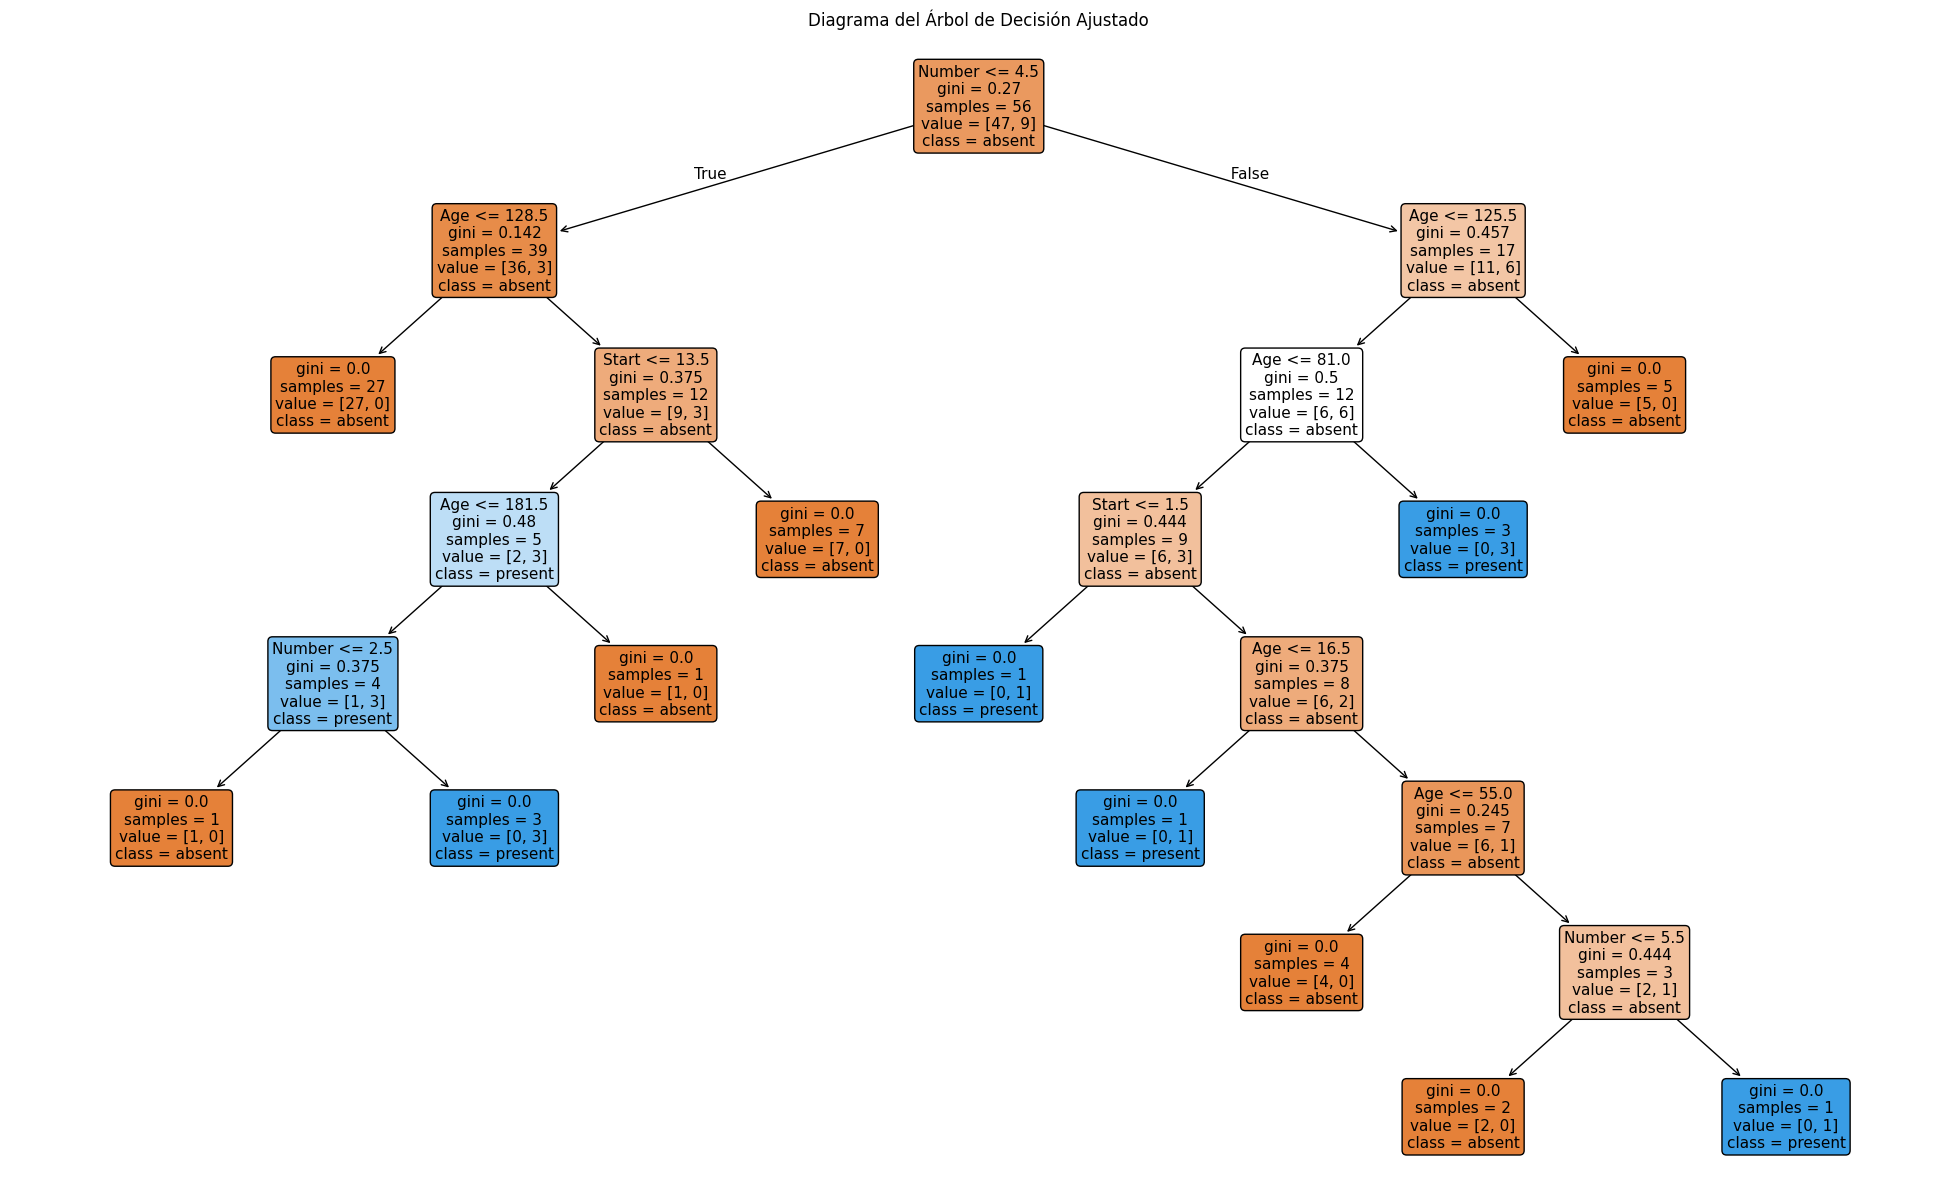

In [13]:
from sklearn.tree import plot_tree

# Configuramos un lienzo grande
plt.figure(figsize=(25, 15))

# Generamos el gráfico
# filled=True: Colorea los nodos según la clase mayoritaria (Azul=Absent, Naranja=Present)
# rounded=True: Bordes redondeados (estético)
_ = plot_tree(dtree,
              feature_names=X.columns,
              class_names=dtree.classes_,
              filled=True,
              rounded=True,
              fontsize=11)

plt.title("Diagrama del Árbol de Decisión Ajustado")
plt.show()

### Interpretación del Árbol Ajustado

El gráfico revela la estructura de decisiones del modelo:

1.  **Nodos Puros:** El modelo logró encontrar segmentos donde la clasificación es perfecta (`gini = 0.0`), especialmente para la clase mayoritaria (`absent`, color naranja).
2.  **Profundidad Excesiva (Overfitting):** Se observan ramas muy profundas que terminan en hojas con muy pocos ejemplos (`samples = 1` o `samples = 3`).
    *   Esto confirma que el árbol se **sobreajustó** a los datos de entrenamiento, creando reglas demasiado específicas que no generalizan bien para nuevos pacientes.
    *   Esta es la causa técnica del bajo rendimiento observado en el set de prueba.

---
## 6. Modelo de Bosques Aleatorios (Random Forest)

Para mitigar el sobreajuste detectado en el árbol simple y mejorar la sensibilidad ante el desbalance, implementamos un ensamble de tipo **Random Forest**.

In [14]:
from sklearn.ensemble import RandomForestClassifier

# Instanciar el modelo
# n_estimators=200: Crearemos 200 árboles independientes.
# random_state=101: Para replicabilidad.
rfc = RandomForestClassifier(n_estimators=200, random_state=101)

# Entrenar (Ajustar)
rfc.fit(X_train, y_train)

# Predecir (Usando el set de prueba)
rfc_pred = rfc.predict(X_test)

print("✅ Random Forest de 200 árboles entrenado exitosamente.")

✅ Random Forest de 200 árboles entrenado exitosamente.



---

##  7.  Evaluar el performance ¿Qué se observa?

In [15]:
# Evaluación del Random Forest
print("=== Performance: Random Forest (200 Árboles) ===")

# Matriz de Confusión
print("\n--- Matriz de Confusión ---")
print(confusion_matrix(y_test, rfc_pred))

# Reporte de Clasificación
print("\n--- Reporte de Clasificación ---")
print(classification_report(y_test, rfc_pred))

=== Performance: Random Forest (200 Árboles) ===

--- Matriz de Confusión ---
[[17  0]
 [ 6  2]]

--- Reporte de Clasificación ---
              precision    recall  f1-score   support

      absent       0.74      1.00      0.85        17
     present       1.00      0.25      0.40         8

    accuracy                           0.76        25
   macro avg       0.87      0.62      0.62        25
weighted avg       0.82      0.76      0.71        25




---

### Comparativa Tree vs Random Forest

Al contrastar el desempeño del Bosque Aleatorio (200 estimadores) frente al Árbol de Decisión simple, observamos un fenómeno interesante:

### Mejoras Observadas
1.  **Aumento de Exactitud (Accuracy):** El modelo subió de un **56%** a un **76%**.
2.  **Eliminación de Falsos Positivos:** La métrica más destacada es que el Random Forest logró clasificar correctamente al **100% de los pacientes sanos** (Clase `absent` Recall = 1.00). La matriz de confusión muestra 0 Falsos Positivos, frente a los 5 del árbol simple.

### Limitaciones Persistentes
1.  **Sensibilidad Estancada:** A pesar de la mejora global, la capacidad de detectar la enfermedad (Clase `present`) no mejoró. El **Recall** se mantuvo en **0.25**.
2.  **El Problema de los Falsos Negativos:** Ambos modelos fallaron en detectar a 6 de los 8 pacientes enfermos.

### Conclusión General del Estudio
El algoritmo **Random Forest** demostró ser superior en robustez, eliminando el ruido y las falsas alarmas (reducción de varianza). Sin embargo, el **desbalance de clases** y el **pequeño tamaño de la muestra** (n=81) son barreras que el algoritmo no pudo superar por sí solo para mejorar la sensibilidad.

**Recomendación Futura:** Para mejorar la detección clínica, sería necesario aplicar técnicas de balanceo de datos (como SMOTE o Class Weights) o conseguir una muestra de datos más grande.